Plan 

I Construction de la base de données
1) Récupération des données INSEE via l'API pynsee
2) Autres données : scraping et import de fichiers en local
3) Fusion des bases de données

II Statistiques descriptives


III Modéliation
1) Régression classique 
2) Détection de grandes périodes et points de rupture

# I Construction de la base de données

## 1) Récupération des données INSEE via l'API pynsee

Notre sujet abordant des questions de politiques publiques, il nous était impensable de ne pas commencer à chercher des données sur le site de l'INSEE. Et nous avons en effet trouvé ce que nous cherchions. Restait encore la question de l'import des bases de données. 
Une première option s'offrait à nous, plus simple, mais plus répétitive et moins performante : télécharger les bases de données une par une, puis les uploader sur le github. 
La seconde option est celle que nous avons utilisée : nous avons importé les bases de données via l'API pynsee, ce qui nous permettait de ne pas rencontrer les mêmes difficultés. 

In [ ]:
#Download Pypi package 
#pip install pynsee[full]
#pip install matplotlib
#pip install seaborn
#pip install scipy

import subprocess
import pandas as pd
import re
import numpy as np

modules = ['pynsee[full]', 'matplotlib', 'seaborn', 'scipy']

for modules in modules:
    subprocess.check_call(["python", '-m', 'pip', 'install', modules])

from pynsee.utils.init_conn import init_conn
init_conn(insee_key='GvulBMLLd4u26RRdMPxYlvqjvHYa', insee_secret='MvDm1OBD_s1a4A33InvrYRT_wEga')

from pynsee.macrodata import * 
from pynsee.macrodata.get_series_list import get_series_list
from pynsee.macrodata.get_series import get_series

Nous avons ensuite créé deux fonctions : 
- clean_filename : permettait d'avoir un nom de fichier 'propre' en ne gardant que des caractères alphanumériques
- import_and_save_data : permet d'importer le fichier souhaité (via l'id_bank de l'INSEE) en le renommant (en donnant le nom souhaité)

In [ ]:
def clean_filename(name):
    return re.sub(r'[^a-zA-Z0-9]', '_', str(name))

def import_and_save_data(id_bank, dataframe_name):
    data = get_series(id_bank)
    data_filtered = data.loc[:, ['DATE', 'OBS_VALUE']] #Sélection des variables d'intérêt
    data_filtered['DATE'] = pd.to_datetime(data_filtered['DATE'])

    new_column_name = clean_filename(dataframe_name) 
    data_filtered = data_filtered.rename(columns={'OBS_VALUE': new_column_name}) # Renommer la colonne OBS_VALUE avec le nom du df
    print(data_filtered.head()) #Vérification des données

    csv_filename = f'datas/{clean_filename(dataframe_name)}_filtered.csv'
    data_filtered.to_csv(csv_filename, index=False) #Sauvegarde dans un fichier csv

    return data_filtered

Il ne nous restait donc plus qu'à exécuter le code pour les données que nous souhaitions importer : 

In [ ]:
governement_negotiable_debts = import_and_save_data('001711531', 'negotiable_debts')
data_firms_creation = import_and_save_data('010755537', 'firms_creation')
data_unemployment_rate = import_and_save_data('001515842', 'unemployment_rate')
data_BOP = import_and_save_data('001694057', 'BOP')
data_natality_rate = import_and_save_data('000436392', 'natality_rate')
data_business_insolvencies = import_and_save_data('001656164', 'business_insolvencies')

## 2) Import des autres données : 

   ### 2-1 Taux de change et CAC40

Afin de récupérer le taux de change ainsi que l'indice du CAC 40, il n'était pas possible de recourir à la base de données de l'INSEE. Nous avons cependant trouvé des données en open-data, disponibles à ces adresses : 
- https://www.investing.com/currencies/eur-usd-historical-data pour le taux de change au certain €/$
- https://fr.investing.com/indices/france-40-historical-data pour le CAC 40

Cette méthode présente néanmoins les mêmes désavantages que ceux listés pour la première option de l'import des bases de données de l'INSEE. Nous l'avons donc seulement choisie en raison du nombre limité de bases de données à importer (deux) et d'absence d'autres bases aussi accessibles et complètes.
Il ne suffisait que de retravailler les données afin d'obtenir le format de date souhaité et le format anglo-saxon pour les float (. à la place de ,)

In [ ]:
import pandas as pd
import os

#NOTE : essayer d'upload les fichiers sur GITHUB pour que ce soit plus reproductible

destination_folder = "datas"
files = {
    'C:\\Users\\mathi\\Downloads\\CAC 40 Historical Data (2).csv': 'CAC_40.csv',
    'C:\\Users\\mathi\\Downloads\\EUR_USD Historical Data (3).csv': 'EUR_USD.csv'
}

for file_path, new_name in files.items():
    df = pd.read_csv(file_path, encoding='utf-8')
    df.rename(columns={'Date': 'DATE'}, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y', errors='coerce') #Conversion de la date à un format standard
    df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')
    print("date successful")

    if new_name == 'CAC_40.csv':    
        df = df[['DATE', 'Price']]
        df.rename(columns={'Price': 'Valuation'}, inplace=True)
        print(new_name, df.head())
        df['Valuation'] = df['Valuation'].str.replace('.', '').str.replace(',', '.').str.replace('"', '').astype(float)
    
    elif new_name == 'EUR_USD.csv':
        df = df[['DATE', 'Price']]
        df.rename(columns={'Price': 'Exch_rate'}, inplace=True)
        print(new_name, df.head())
        df['Exch_rate'] = df['Exch_rate'].replace({',': '.', '"': ''}, regex=True).astype(float)

    new_path = os.path.join(destination_folder, new_name)
    df.to_csv(new_path, index=False)

### 2-2 Taux directeurs : scraping

Un autre challenge restait celui de la récupération des taux directeurs. En effet, ceux-ci jouent un rôle clé dans l'évolution de la dette en ce qu'ils déterminent les intérêts à payer. Nous avons décidé de les récupérer sur le site de la Banque Centrale Européenne (BCE, ou ECB en anglais). Cette fois-ci avec plusieurs difficultés : 
- les années n'étaient pas présentes sur toutes les lignes et pouvaient fonctionner par "groupe"  
- les dates n'étaient pas au format standard mais avec des abréviations
- les chiffres négatifs étaient précédés d'un U+2212 au lieu du - classique
- les numéros de note pour les notes de bas de page étaient affichés dans la date. Ex : 15 Oct.4

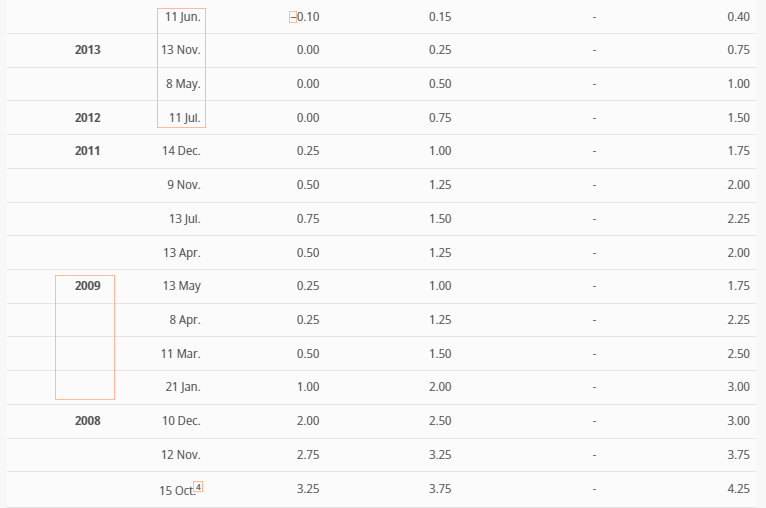

In [ ]:
#Import des librairies
# pip install -q lxml
# pip install webdriver-manager

import subprocess
import pandas as pd

modules = ["lxml", "webdriver-manager", "bs4"]
for module in modules:
    subprocess.run(["pip", "install", module])

import bs4
import lxml
import urllib
import re


from urllib import request
from datetime import datetime

url_ecb = "https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html"

request_text = request.urlopen(url_ecb).read()
page = bs4.BeautifulSoup(request_text, "html.parser")

policy_rates_df = page.find('table')
table_body = policy_rates_df.find('tbody')
rows = table_body.find_all('tr')

#Compléter la première colonne avec la valeur précédente s'il n'y en a aucune 

data_temp = []

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if cols[0] == '':
        cols[0] = previous_value
    previous_value = cols[0]
    data_temp.append(cols)

columns = ['Year', 'Date', 'Deposit facility', 'Fixed rate', 'Minimum bid rate', 'Marginal lending facility']
policy_rates_df = pd.DataFrame(data_temp, columns=columns)
policy_rates_df['Deposit facility'] = policy_rates_df['Deposit facility'].str.replace('−', '-') #Remplacement du signe U+2212 avec un signe moins - 

print(policy_rates_df.head())


Une fois le problème des années pas toujours présentes dans la première colonne, il nous a fallu régler les deux problèmes restants (pas de date dans un format standard comme DD/MM/YYYY, mais avec des abréviations).
Nous avons d'abord tenté d'utiliser pd.to_datetime, mais il s'est avéré qu'il n'arrivait pas bien à assimiler le format. Nous avons alors eu l'idée d'utiliser une expression régulière : 
- (\d{1,2}): correspond à 1 ou 2 chiffres (\d) qui représentent le jour du mois 
- \s: un espace ou une tabulation (dans notre cas, l'espace entre le jour et l'abréviation du mois)
- (\w{3}): 3 caractères alphanumériques, représentant les abréviations de tous les mois étaient abrégés avec 3 caractères alphanumériques

Nous avons ensuite utilisé la fonction Map afin de passer des abréviations des mois au format souhaité YYYY-MM-DD

In [ ]:
extracted_date = policy_rates_df['Date'].str.extract(r'(\d{1,2})\s(\w{3})')

month_map = {
    'Jan': '-01-', 'Feb': '-02-', 'Mar': '-03-',
    'Apr': '-04-', 'May': '-05-', 'Jun': '-06-',
    'Jul': '-07-', 'Aug': '-08-', 'Sep': '-09-',
    'Oct': '-10-', 'Nov': '-11-', 'Dec': '-12-'
}

# Construction de la date tel que le format est YYYY-MM-DD
policy_rates_df['Date'] = (
    policy_rates_df['Year'].astype(str) + 
    extracted_date[1].map(month_map) + 
    extracted_date[0].astype(str)
)

policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'], format='%Y-%m-%d', errors='coerce')
print(policy_rates_df.head())

policy_rates_df.drop(['Year', 'Minimum bid rate'], axis=1, inplace=True) #Drop de la colonne Year comme elle est redondante avec la colonne Date, et Minimum bid rate n'est pas pertinent


#On s'assure que les colonnes souhaitées sont bien du type float 

field_float = ['Deposit facility', 'Fixed rate', 'Marginal lending facility']

for col in field_float:
    policy_rates_df[col] = pd.to_numeric(policy_rates_df[col], errors='coerce')

policy_rates_df[field_float] = policy_rates_df[field_float].astype(float)

 
print(policy_rates_df.head())  

policy_rates_df.to_csv('datas/' + 'policy_rates.csv', index=False) #Sauvegarde du fichier en csv

## 3) Fusion des bases de données

L'objectif est d'avoir une base de données mensuelle avec tous nos indicateurs. Celle-ci s'obtient par une jointure des bases précédentes sur la colonne 'DATE', au format YYYY-MM-DD. Il a fallu retravailler deux éléments : 

### 3-1 Bases de données trimestrielles

Les données trimestrielles présentaient deux problématiques différentes, avec deux réponses différentes : 
- interpolation linéaire : s'il y a 5% de taux de chômage au mois m et 8% à la date m+3, alors on considère qu'il y a 6% en m+1 et 7% en m+2
- répartition uniforme : s'il y a 3000 faillites au cours du premier trimestre d'une année, alors on considère qu'il y a eu 1000 faillites par mois

In [ ]:
data_folder = 'datas/'

# Chargement des fichiers CSV depuis le dossier "datas"
business_insolvencies = pd.read_csv(data_folder + 'business_insolvencies_filtered.csv')
firms_creation = pd.read_csv(data_folder + 'firms_creation_filtered.csv')
unemployment_rate = pd.read_csv(data_folder + 'unemployment_rate_filtered.csv')

def fill_missing_months_linear(data, column_name, output_folder='datas/'):
    # Conversion de la colonne 'DATE' en type datetime et tri par date
    data['DATE'] = pd.to_datetime(data['DATE'])
    data.set_index('DATE', inplace=True)
    
    data_resampled = data.resample('MS').mean()
    data_resampled = data_resampled.asfreq('MS')
    data_resampled = data_resampled.interpolate(method='linear')
    
    csv_filename = f'{output_folder}/{clean_filename(column_name)}_mensual.csv'
    data_resampled.to_csv(csv_filename, index=True)
    
    return data_resampled

def fill_missing_months_divided(data, column_name, output_folder='datas/'):

    data['DATE'] = pd.to_datetime(data['DATE'])    
    data.set_index('DATE', inplace=True)

    data_resampled = data.resample('MS').mean() # Rééchantillonnage à une fréquence mensuelle
    data_resampled = data_resampled.asfreq('MS') # Ajout de lignes pour les mois manquants
    data_resampled = data_resampled / 3 #Répartition uniforme
    data_resampled = data_resampled.fillna(method='ffill') # remplacement des valeurs manquantes par la valeur du mois précédent (divisée par 3)

    csv_filename = f'{output_folder}/{clean_filename(column_name)}_mensual.csv'
    data_resampled.to_csv(csv_filename, index=True)
    
    return data_resampled

filled_divided_business_insolvencies = fill_missing_months_divided(business_insolvencies, 'business_insolvencies')
filled_linear_unemployment_rate = fill_missing_months_linear(unemployment_rate, 'unemployment_rate')

### 3-2 Complétion par les valeurs les plus proches

Etant donné que notre objectif était d'avoir une base de données avec des données mensuelles et que les changements de taux n'ont pas lieu à date régulière, il a fallu créer un nouveau dataframe avec des données mensuelles, et le remplir avec les valeurs les plus proches.

In [ ]:
policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'], format='%Y-%m-%d', errors='coerce')
numeric_cols = policy_rates_df.select_dtypes(include='number').columns
policy_rates_df[numeric_cols] = policy_rates_df[numeric_cols].ffill()

#Creation of a new dataframe with monthly data (month starts) 
date_range = pd.date_range(start=min(policy_rates_df['Date']), end=max(policy_rates_df['Date']), freq='MS')
policy_rates_monthly = pd.DataFrame({'Date': date_range})

# Find closest date in the original df and complete the values in the monthly df

for index, row in policy_rates_monthly.iterrows():
    closest_date = policy_rates_df['Date'].iloc[(policy_rates_df['Date'] - row['Date']).abs().argsort()[:1]].values[0]    
    policy_rates = policy_rates_df[policy_rates_df['Date'] == closest_date].drop('Date', axis=1)
    policy_rates_monthly.loc[index, policy_rates.columns] = policy_rates.values[0]

policy_rates_monthly = policy_rates_monthly.rename(columns={'Date': 'DATE'}) 
print(policy_rates_monthly.head())
policy_rates_monthly.to_csv('datas/policy_rates_monthly.csv', index=False)


### 3-3 Jointure et base de données finale

Il ne nous reste alors plus qu'à faire la jointure entre les différentes bases de données pour les agréger dans un seul fichier.


In [ ]:
import os

data_folder = 'datas/'

# Chargement des fichiers CSV depuis le dossier "datas"
negotiable_debts = pd.read_csv(data_folder + 'negotiable_debts_filtered.csv')
final_data = negotiable_debts[negotiable_debts['DATE'] >= '2008-01-01']
final_data['DATE'] = pd.to_datetime(final_data['DATE'])

datas_to_merge = ['BOP_filtered',
                'business_insolvencies_mensual',
                'firms_creation_filtered', 
                'natality_rate_filtered',
                'unemployment_rate_mensual',
                'CAC_40',
                'EUR_USD',
                'policy_rates_monthly'
                ]

for data in datas_to_merge:
    
    df = pd.read_csv(data_folder + data + '.csv')
    df['DATE'] = pd.to_datetime(df['DATE'])  # Conversion en format datetime
    df = df[(df['DATE'] >= '2009-01-01') & (df['DATE'] <= '2023-04-01')]  #Filtrage temporel en raison de la disponibilité des données
    df = df.sort_values('DATE')
    final_data = pd.merge(final_data, df, on='DATE', how='outer')

final_data = final_data.reset_index(drop=True).sort_values('DATE')



final_filename = os.path.join(data_folder, 'final_data.csv')
final_data.to_csv(final_filename, index=False)
print(final_data.head())

# II Statistiques descriptives



## 1) Variables macroéconomiques

Nous avons créé une fonction qui servait à créer des scatterplots si l'on précisait la base de données, afin d'avoir un premier aperçu.
Concernant la régression polynomiale, nous nous sommes limités à un degré de 3. En effet, s'il était possible d'avoir une régression polynomiale avec des degrés plus importants et un meilleur R², des coefficients pour un x^10 ne sont pas très parlants.

NB : les coefficients affichés sur les scatterplots s'arrêtent à deux chiffres après la virgule. Ainsi, si 0.00 est affiché, le coefficient n'est pas nécessairement nul. Cependant le signe du coefficient reste intéressant à interpréter.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression


from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import os

data_folder = 'datas/'


def create_scatter_plot(data, plot_title, x_label, y_label, output_filename):
    # Importation des données et nettoyage des valeurs NaN dans la colonne 'DATE'
    data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')
    data = data.dropna(subset=['DATE'])
    
    # Choix d'une palette de couleurs pastel et police spécifique
    sns.set_palette("pastel")  
    prop = fm.FontProperties(fname=fm.findfont(fm.FontProperties(family='Arial')))
    
    # Création du scatterplot
    plt.scatter(data['DATE'], data[y_label], label='Données réelles')
    plt.xlabel(x_label, fontproperties=prop)
    plt.ylabel(y_label, fontproperties=prop)
    plt.title(plot_title, fontproperties=prop)
    
    # Ajout d'une ligne de régression polynomiale
    days_since_start = (data['DATE'] - data['DATE'].min()).dt.days.values
    coefficients = np.polyfit(days_since_start, data[y_label], 3)  
    polynomial = np.poly1d(coefficients)
    
    # Générer les valeurs pour la régression polynomiale
    x_values = np.linspace(days_since_start.min(), days_since_start.max(), 100)
    y_values = polynomial(x_values)
    
    # Affichage de la régression polynomiale
    plt.plot(pd.to_datetime(data['DATE'].min()) + pd.to_timedelta(x_values, unit='D'), y_values, color='red', label='Régression polynomiale')
    
    # Affichage de l'équation de la régression polynomiale
    equation = f'Equation: y = {coefficients[0]:.2f}x^3 + {coefficients[1]:.2f}x² + {coefficients[2]:.2f}x + {coefficients[3]:.2f}'
    plt.annotate(equation, xy=(0.025, 0.8), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.8), fontproperties=prop)
     
    # Calcul du coefficient de détermination R^2
    slope, intercept, r_value, p_value, std_err = linregress(days_since_start, data[y_label])
    r_squared = r_value ** 2
    
    # Affichage du coefficient de détermination R^2
    plt.text(0.95, 0.02, f'R² : {r_squared:.4f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8), fontproperties=prop)
    
    # Affichage et sauvegarde
    plt.legend(prop=prop)
    plt.savefig(os.path.join('data_visualisation', output_filename), bbox_inches='tight')
    plt.show()


On l'exécute maintenant pour tous les fichiers : 

In [ ]:
negotiable_debts = pd.read_csv(os.path.join(data_folder + 'negotiable_debts_filtered.csv'))
bop = pd.read_csv(os.path.join(data_folder, 'BOP_filtered.csv'))
business_insolvencies = pd.read_csv(os.path.join(data_folder, 'business_insolvencies_filtered.csv'))
firms_creation = pd.read_csv(os.path.join(data_folder, 'firms_creation_filtered.csv'))
natality_rate = pd.read_csv(os.path.join(data_folder, 'natality_rate_filtered.csv'))
unemployment_rate = pd.read_csv(os.path.join(data_folder, 'unemployment_rate_filtered.csv'))
cac_40 = pd.read_csv(os.path.join(data_folder, 'CAC_40.csv'))
eur_usd = pd.read_csv(os.path.join(data_folder, 'EUR_USD.csv'))

# Utilisation de la fonction avec spécification des noms de fichiers de sortie
create_scatter_plot(negotiable_debts, 'Evolution de la dette négociable de l Etat', 'Date', 'negotiable_debts', 'negotiable_debts_scatter.png')
create_scatter_plot(firms_creation, 'Evolution du nombre de firmes créées', 'Date', 'firms_creation', 'firms_creation_scatter.png')
create_scatter_plot(unemployment_rate, 'Evolution du taux de chômage', 'Date', 'unemployment_rate', 'unemployment_rate_scatter.png')
create_scatter_plot(bop, 'Evolution de la balance des paiements', 'Date', 'BOP', 'BOP_scatter.png')
create_scatter_plot(natality_rate, 'Evolution du taux de natalité', 'Date', 'natality_rate', 'natality_rate_scatter.png')
create_scatter_plot(business_insolvencies, 'Evolution du nombre de défaillances de firmes par date de jugement en France tout secteur confondu', 'Date', 'business_insolvencies', 'business_insolvencies_scatter.png')
create_scatter_plot(cac_40, 'Evolution de la valeur du CAC 40', 'Date', 'Valuation', 'cac_40_scatter.png')
create_scatter_plot(eur_usd, 'Evolution du taux de change EUR/USD', 'Date', 'Exch_rate', 'eur_usd_scatter.png')


On peut remarquer plusieurs éléments grâce à ces tableaux :
- **l'évolution de la dette négociable de l'Etat est relativement linéaire depuis 2009**. Cependant on peut observer un effet marginal négatif (un coefficient de -0.09 pour x²), que l'on pourrait interpréter comme une peur du surendettement, notamment autour du seuil des 100% du PIB

- **la balance des paiements est sur une tendance positive** : la balance des paiements : contraire à l'idée reçue, la France ne dépend pas du reste du monde.Certes, la balance commerciale (i.e. la différence entre exportations et importations de marchandises) est négative, c'est avant tout lié à la position  économique française dans le monde et son passage à une économie de services, avec un fort développement du tertiaire au détriment des autres secteurs (notamment la désindustrialisation).

-   **concernant le taux de chômage, on observe de véritables cycles correspondant aux cycles macroéconomiques**:
    - au début des années 1980, une sortie du plein emploi qu'avait connu la France des Trente Glorieuses avec le contrecoup des chocs pétroliers 
    - un pic durant les années 1990 lié à une récession mondiale, conjuguée à un basculement de plein pied dans la mondialisation (notamment du secteur industriel), avant que la révolution des NTIC permette de faire baisser le chômage
    - au début des années 2000, un resserrement des taux de long-terme et une explosion de la bulle Internet induisant une hausse du chômage
    - la conjonction de la crise financière de 2008 et de la crise des dettes souveraines à partir de 2010
    - puis à partir du milieu des années 2010, une baisse du chômage liée à une baisse des taux d'intérêt afin de stimuler l'économie

    Sachant que les données remontent à 1980, il est tout à fait normal qu'une régression polynomiale de degré 3 soit incapable de saisir ce caractère cyclique, d'autant que le taux de chômage est très dépendant du contexte macroéconomique.

- **concernant l'évolution du CAC 40, on retrouve le même caractère cyclique** : 
    - la bulle Internet le place juste en-dessous des 7000 points, avant que son éclatement provoque son effondrement.
    - on observe un effondrement similaire après la crise financière de 2008 et un ralentissement de la reprise avec la crise des dettes souveraines au début des années 2010.
    - on remarque ensuite une hausse, même si des épisodes comme le Covid ou le déclenchement de la guerre en Ukraine provoquent des baisses temporaires.





## 2) Politique monétaire : taux directeurs

On s'intéresse désormais aux taux directeurs de la BCE qui dictent la politique monétaire suivie. 

In [ ]:
selected_columns = ['Date', 'Deposit facility', 'Marginal lending facility'] #Sélection des colonnes d'intérêt
policy_rates_df = pd.read_csv('datas/policy_rates.csv', usecols=selected_columns, encoding='utf-8')
policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'])

fig, ax = plt.subplots(figsize=(8, 5))

rate_colors = {'Deposit facility': 'navy', 'Marginal lending facility': 'green'}
for column in rate_colors:
    ax.scatter(policy_rates_df['Date'], policy_rates_df[column], label=column, color=rate_colors[column], marker='+', s=25)

ax.set_ylim(-0.75, 6)
ax.set_yticks(np.arange(-0.75, 6, 0.25))
ax.set_title('Policy Rates Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Rate')

#Affichage des années sur l'axe des abscisses pour une meilleure visibilité
years = mdates.YearLocator(1)
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=45)
plt.grid(linestyle=':', alpha=0.5) 

#Ajout d'une ligne horizontale pour 'Zero Lower Bound'
ax.axhline(y=0, color='darkred', linestyle='--', linewidth=1.25, label='Zero Lower Bound')  
ax.legend()

plt.savefig('data_visualisation/policy_rates_plot.png')
plt.show()

Après 2008, les banques centrales ont connu une inflation extrêmement faible, avec une possible matérialisation du risque de déflation. Pour quelles raisons y avait-il matérialisation possible du risque de déflation ?
- une baisse spectaculaire des progrès de productivité du travail et de la productivité globale des facteurs : la croissance potentielle des économies a donc diminué, donc il y avait peu de raison d’avoir une inflation forte.
- la globalisation a continué lors de cette période : les nouvelles chaînes mondiales de valeur optimisent la production de biens et de services, et donc pèsent sur les prix en intégrant par exemple des entreprises chinoises, afin d'obtenir des prix aussi bas que possibles.
- la faible capacité de la main d'oeuvre (syndicats et salariés à faible qualification) à obtenir des augmentations de rémunération - à la fois réelles et nominales. Les coûts unitaires de production sont restés très plats, donc l’inflation - corrélée à ces coûts - a peu augmenté peu.	
- enfin, un excès d’épargne au niveau mondial, provoquant des taux d’intérêt réels particulièrement bas en raison de l’excès d’épargne par rapport aux investissements souhaités

C’est pour cela que les banques centrales ont mené des politiques monétaires extraordinairement accommodantes comme le quantitative easing et les taux d'intérêt négatifs : on voit une véritable chute des taux d'intérêt directeurs, et notamment du taux marginal de prêt (taux utilisé par les banques pour emprunter à très court terme auprès de la BCE), tandis que le taux marginal de dépôt devient négatif (taux auquel les banques déposent des fonds excessifs à la BCE), encourageant ainsi l'octroi de prêts avec ces fonds plutôt que leur conservation, afin de stimuler l'activité économique. 

En revanche, le Covid a changé la situation : l'inflation a refait son entrée en Europe, et avec elle une hausse des taux directeurs. On peut l'expliquer par plusieurs raisons : 
•	la reprise post-covid : les agents ont retrouvé la capacité d’acheter, et ne sont plus inhibés par l’ensemble des contraintes du Covid : il ya augmentation de la demande, encouragée par la politique budgétaire et l'épargne Covid aussi ; mais en face la gêne du Covid a continué, ce qui fait que l'offre était encore trop insuffisante  

•	les politiques budgétaires et monétaires ultra-accommodantes jouent un grand rôle : elles se sont accumulées sur de longues périodes

•	la déglobalisation : au lieu d’une multiplication de nouvelles chaînes de valeur, il y a une tentative mondiale de se protéger des inconvénients des chaînes de valeur au niveau mondial (interruption d’un élément perturbant le reste), avec l'irruption d'éléments géostratégiques.

•	arrêt de la faible capacité de négociation du travail : on a vu l'émergence d’une certaine fureur de la classe moyenne de blue collars aux Etats Unis, et en France avec les revendications sociales. Il s'est construit une véritable critique des inégalités ainsi que des superprofits pendant le Covid.

•	d'autres raisons : un retard de réaction des banques centrales (5 mois entre l’annonce que l’inflation n’est pas seulement transitoire et la hausse des taux d’intérêt), la guerre en Ukraine, la nécesssité du financement de la transition verte (et la perspective de long-terme de la hausse des prix de certains produits) 

## 3) Plotly 

On a ensuite développé un plotly pour observer les corrélations.

NB : il est conseillé, pour des questions de visibilité, d'exécuter le code du fichier data_visualisation/plotly_plots car l'affichage est ici limité par la taille du terminal, tandis que l'exécution permet d'ouvrir une page web interactive

In [1]:
#pip install plotly
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

data_folder = 'datas/'
final_data = pd.read_csv(os.path.join(data_folder, 'final_data.csv'), parse_dates=['DATE'])

# Création d'une figure avec Plotly Express
fig = px.scatter_matrix(
    final_data,
    dimensions=['BOP', 'business_insolvencies', 'firms_creation', 'natality_rate', 'unemployment_rate', 'Valuation', 'Exch_rate', 'Fixed rate', 'negotiable_debts'],
    color='negotiable_debts',
    title='Relations entre différentes variables et la dette négociable'
)

# Mettre à jour l'apparence du graphique
fig.update_traces(marker=dict(size=5), diagonal_visible=False)

# Ajout du graphique de dispersion 3D
scatter_3d = go.Scatter3d(
    x=final_data['unemployment_rate'],
    y=final_data['Valuation'],
    z=final_data['negotiable_debts'],
    mode='markers',
    marker=dict(size=5, color=final_data['negotiable_debts'], colorscale='Viridis')
)

fig.add_trace(scatter_3d)
fig.update_traces(marker=dict(size=5))


# Mise à jour du layout pour ajuster l'angle des étiquettes sur l'axe y
fig.update_layout(
    title_font=dict(family='Arial', size=20, color='black'),  # Police, taille et couleur du titre
    font=dict(family='Arial', size=10, color='black'),  # Police, taille et couleur du texte
    scene=dict(
        yaxis=dict(
            title_font=dict(family='Arial', size=15, color='black'),  # Police, taille, couleur de l'axe y
            tickmode='array',
            tickvals=list(range(len(final_data.columns))),
            ticktext=list(final_data.columns),
            categoryorder='array',
            categoryarray=list(final_data.columns)
        ),
    )
)

fig.show()

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Tableau de Bord de la Dette Négociable"),

    # Filtrage temporel
    dcc.RangeSlider(
        id='date-slider',
        marks={i: str(date) for i, date in enumerate(final_data['DATE'])},
        min=0,
        max=len(final_data) - 1,
        value=[0, len(final_data) - 1],
        step=1
    ),

    # Graph principal
    dcc.Graph(id='main-graph'),
    # Graph comparatif
    dcc.Graph(id='comparison-graph')
])

# Définition des callbacks pour la mise à jour des graphiques
@app.callback(
    Output('main-graph', 'figure'),
    [Input('date-slider', 'value')]
)
def update_graph(selected_dates):
    # Extraction des données pour les dates sélectionnées
    selected_data = final_data.iloc[selected_dates[0]:selected_dates[1] + 1]

    # Graphique principal (à adapter selon vos besoins)
    main_fig = make_subplots(rows=8, cols=1, shared_xaxes=True)

    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['negotiable_debts'], mode='lines', name='Dette Négociable'), row=1, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['unemployment_rate'], mode='lines', name='Taux de Chômage'), row=2, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['BOP'], mode='lines', name='Balance des paiements - Crédit - Transactions courantes'), row=3, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['business_insolvencies'], mode='lines', name="Nombre de défaillances d'entreprises par date de jugement - Données brutes - France - Tous secteurs d'activité"), row=4, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['firms_creation'], mode='lines', name="Nombre de création d'entreprises par date de jugement - Données brutes - France - Tous secteurs d'activité"), row=5, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['natality_rate'], mode='lines', name='Taux de natalité'), row=6, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['Valuation'], mode='lines', name='Taux de change au certain €/$'), row=7, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['Fixed rate'], mode='lines', name='Taux directeur'), row=8, col=1)

    main_fig.update_layout(title='Données Sélectionnées')
    main_fig.update_layout(height=1500)

    return main_fig

"""
# Exécution de l'application
if __name__ == '__main__':
    app.run_server(debug=True)
"""

"\n# Exécution de l'application\nif __name__ == '__main__':\n    app.run_server(debug=True)\n"